In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stats
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Unsupervised Learning

In [39]:
df=pd.read_csv('credit_card.csv',encoding='latin-1')
pd.set_option('display.max_columns',None)  # use to show all the column in data frame
print("Shape:", df.shape)
display(df.head())

Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [41]:
df.info()

df.describe()

df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

###   Primary EDA of categorical / categorical-like features 

In [44]:
# Note: dataset mostly numeric; categorical-like fields: CUST_ID (ID), TENURE (discrete), PRC_FULL_PAYMENT (fractions, often 0/1), transaction counts
print("\n--- Q1: Primary analysis of categorical-like features ---")

# 1) CUST_ID: uniqueness check
print("Unique CUST_ID:", df['CUST_ID'].nunique(), "rows:", df.shape[0])

# 2) TENURE (discrete values) - frequency
print("\nTENURE value counts (top):")
print(df['TENURE'].value_counts(normalize=True).head(10))

# 3) PRC_FULL_PAYMENT - distribution and common values
print("\nPRC_FULL_PAYMENT - value counts / common ranges:")
print(df['PRC_FULL_PAYMENT'].describe())
# show fraction that are zero and 1 (if those exact values present)
print("Fraction with PRC_FULL_PAYMENT == 0:", (df['PRC_FULL_PAYMENT']==0).mean())
print("Fraction with PRC_FULL_PAYMENT == 1:", (df['PRC_FULL_PAYMENT']==1).mean())

# 4) Transaction counts (PURCHASES_TRX, CASH_ADVANCE_TRX)
for c in ['PURCHASES_TRX','CASH_ADVANCE_TRX']:
    if c in df.columns:
        print("\n", c, "describe:")
        print(df[c].describe())

# SHORT INTERPRETATION (to include in your answer):
# - CUST_ID is unique id: dataset is one row per customer (no useful categories there).
# - TENURE often concentrated at a single value (e.g., 12), so low variance; not very informative.
# - PRC_FULL_PAYMENT often 0 for many customers (majority don't pay full), small group pay full — useful for segmentation (full payers vs non-full payers).
# - Transaction count variables are skewed: many customers with few transactions, some heavy users.


--- Q1: Primary analysis of categorical-like features ---
Unique CUST_ID: 8950 rows: 8950

TENURE value counts (top):
TENURE
12    0.847374
11    0.040782
10    0.026369
6     0.022793
8     0.021899
7     0.021229
9     0.019553
Name: proportion, dtype: float64

PRC_FULL_PAYMENT - value counts / common ranges:
count    8950.000000
mean        0.153715
std         0.292499
min         0.000000
25%         0.000000
50%         0.000000
75%         0.142857
max         1.000000
Name: PRC_FULL_PAYMENT, dtype: float64
Fraction with PRC_FULL_PAYMENT == 0: 0.6595530726256983
Fraction with PRC_FULL_PAYMENT == 1: 0.05452513966480447

 PURCHASES_TRX describe:
count    8950.000000
mean       14.709832
std        24.857649
min         0.000000
25%         1.000000
50%         7.000000
75%        17.000000
max       358.000000
Name: PURCHASES_TRX, dtype: float64

 CASH_ADVANCE_TRX describe:
count    8950.000000
mean        3.248827
std         6.824647
min         0.000000
25%         0.000000
50

###  Perform the following Exploratory Data Analysis tasks:
##### a. Missing Value Analysis
##### b. Outlier Treatment using the Z-score method
##### c. Deal with correlated variables


In [47]:
# a. Missing Value Analysis

print("\n--- Q2 (a): Missing Value Analysis ---")
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
missing_table = pd.concat([missing_counts, missing_pct], axis=1, keys=['MissingCount','MissingPct'])
display(missing_table)

# Strategy: For numeric fields: impute median. If many values missing, mention in report and consider domain-specific imputation.
df2 = df.copy()
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
df2[num_cols] = df2[num_cols].fillna(df2[num_cols].median())
print("Missing after median imputation (numeric):", df2[num_cols].isnull().sum().sum())

# If there are non-numeric missing columns, treat appropriately (mode or separate category).


--- Q2 (a): Missing Value Analysis ---


,MissingCount,MissingPct
MINIMUM_PAYMENTS,313,3.497207
CREDIT_LIMIT,1,0.011173
CUST_ID,0,0.000000
BALANCE,0,0.000000
PRC_FULL_PAYMENT,0,0.000000
PAYMENTS,0,0.000000
PURCHASES_TRX,0,0.000000
CASH_ADVANCE_TRX,0,0.000000
CASH_ADVANCE_FREQUENCY,0,0.000000
PURCHASES_INSTALLMENTS_FREQUENCY,0,0.000000


Missing after median imputation (numeric): 0


In [49]:
# b. Outlier Treatment using the Z-score method

print("\n--- Q2 (b): Outlier Treatment (Z-score) ---")
# We'll remove rows having absolute Z-score > 3 in any numeric column (common approach).
z = np.abs(stats.zscore(df2[num_cols]))
outlier_mask = (z > 3).any(axis=1)
print("Rows flagged as outlier (any |z|>3):", outlier_mask.sum(), "out of", df2.shape[0])
df_no_outliers = df2.loc[~outlier_mask].reset_index(drop=True)
print("Shape after removing outliers:", df_no_outliers.shape)

# NOTE: Alternatively you can cap outliers (winsorize) if removing many rows is undesirable.


--- Q2 (b): Outlier Treatment (Z-score) ---
Rows flagged as outlier (any |z|>3): 1516 out of 8950
Shape after removing outliers: (7434, 18)


In [51]:
# c. Deal with correlated variables

print("\n--- Q2c: Correlation & handling ---")
# compute abs correlation matrix
corr = df_no_outliers[num_cols].corr().abs()
# list pairs with high correlation (> 0.90)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = [(col, idx, upper.loc[idx,col]) for col in upper.columns for idx in upper.index if (upper.loc[idx,col] > 0.90)]
# easier: find columns to drop (one of each highly correlated pair)
to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]
print("Highly correlated columns to drop (threshold 0.90):", to_drop)
# If none, we keep all features. Otherwise drop chosen ones before PCA/clustering.
df_corr_handled = df_no_outliers.drop(columns=to_drop, errors='ignore')
df_corr_handled.head()


--- Q2c: Correlation & handling ---
Highly correlated columns to drop (threshold 0.90): []


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


###  Perform dimensionality reduction using PCA such that the 95% of the variance is explained


--- Q3: PCA (retain 95% variance) ---
PCA chosen components: 12
Explained variance ratio (sum): 0.9659412550088523


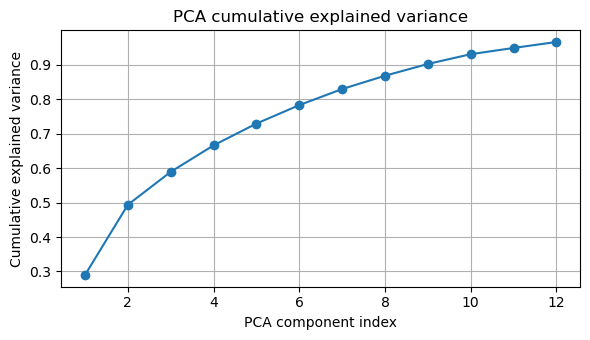

In [54]:
print("\n--- Q3: PCA (retain 95% variance) ---")
# Exclude ID-like columns. If TENURE is mostly constant you may drop it; we keep numeric features except CUST_ID.
features = df_corr_handled.select_dtypes(include=[np.number]).copy()
if 'TENURE' in features.columns:
    # keep or drop TENURE depending on your judgement; here I keep it
    pass

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA selecting components to explain 95% variance
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)
print("PCA chosen components:", pca.n_components_)
print("Explained variance ratio (sum):", pca.explained_variance_ratio_.sum())

# Visualize cumulative explained variance (optional)
plt.figure(figsize=(6,3.5))
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(cumvar)+1), cumvar, marker='o')
plt.xlabel('PCA component index'); plt.ylabel('Cumulative explained variance'); plt.grid(True)
plt.title('PCA cumulative explained variance')
plt.tight_layout()
plt.show()

###  Find the optimum value of k for k-means clustering using the elbow method. Plot the elbow curve.


--- Q4: Elbow method for KMeans ---


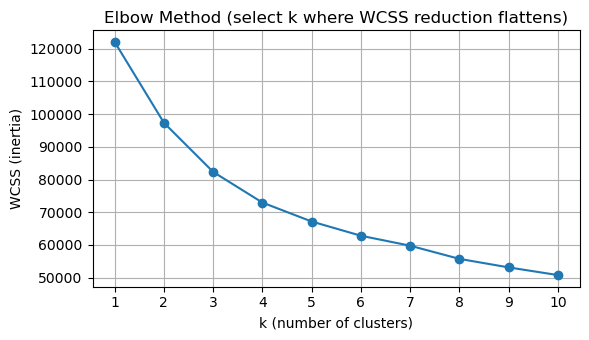

In [57]:
print("\n--- Q4: Elbow method for KMeans ---")
# Choose k range (1 to 10)
ks = list(range(1,11))
wcss = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,3.5))
plt.plot(ks, wcss, marker='o')
plt.xlabel('k (number of clusters)'); plt.ylabel('WCSS (inertia)')
plt.title('Elbow Method (select k where WCSS reduction flattens)')
plt.xticks(ks)
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretation tip: the "elbow" (point of diminishing returns) suggests the optimum k.

###  Find the optimum value of k for k-means clustering using the silhouette score method. Build a K-means clustering model and specify the number of observations in each cluster using a bar plot.


--- Q5: Silhouette method, final KMeans, cluster sizes ---
k=2, silhouette=0.2130
k=3, silhouette=0.2130
k=4, silhouette=0.1926
k=5, silhouette=0.1938
k=6, silhouette=0.2003
k=7, silhouette=0.2014
k=8, silhouette=0.2102
k=9, silhouette=0.2096
k=10, silhouette=0.1909
Best k by silhouette score: 2


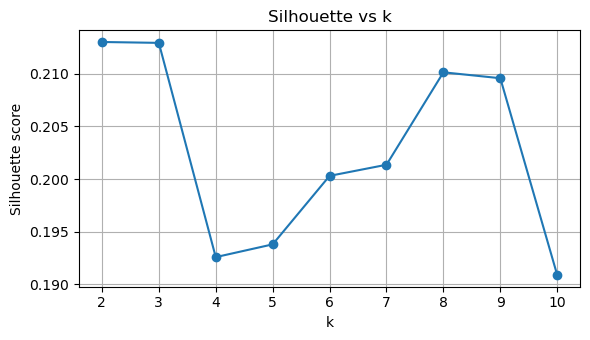

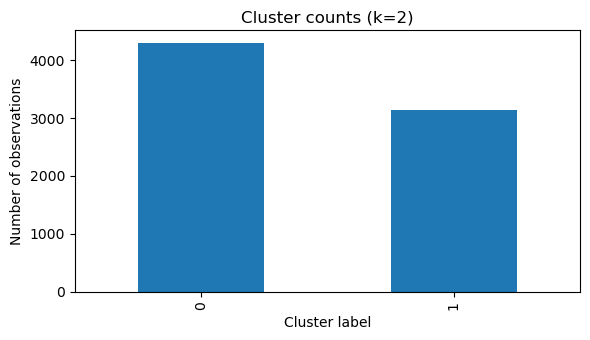

TypeError: agg function failed [how->mean,dtype->object]

In [59]:
print("\n--- Q5: Silhouette method, final KMeans, cluster sizes ---")
sil_scores = []
k_list = list(range(2,11))   # silhouette not defined for k=1
for k in k_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.4f}")

best_k = k_list[int(np.argmax(sil_scores))]
print("Best k by silhouette score:", best_k)

plt.figure(figsize=(6,3.5))
plt.plot(k_list, sil_scores, marker='o')
plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.title('Silhouette vs k'); plt.grid(True)
plt.tight_layout()
plt.show()

# Build the final KMeans model with best_k using PCA components
final_km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
final_labels = final_km.fit_predict(X_pca)

# Add cluster labels to a copy of original (non-scaled) data for profiling
clustered = df_corr_handled.copy()
clustered = clustered.reset_index(drop=True).loc[clustered.index[:X_pca.shape[0]]]  # align shapes
clustered['Cluster'] = final_labels

# Bar plot: number of observations per cluster
counts = clustered['Cluster'].value_counts().sort_index()
plt.figure(figsize=(6,3.5))
counts.plot(kind='bar')
plt.xlabel('Cluster label'); plt.ylabel('Number of observations'); plt.title(f'Cluster counts (k={best_k})')
plt.tight_layout()
plt.show()

# Cluster profiling (mean of features per cluster)
profile = clustered.groupby('Cluster').mean()
display(profile)

# If you want centroids in original units:
# Inverse transform cluster centers from PCA -> scaled -> original feature units
centroids_pca = final_km.cluster_centers_
centroids_scaled = pca.inverse_transform(centroids_pca)
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_orig, columns=features.columns)
centroid_df['Cluster'] = range(best_k)
display(centroid_df)
